In [ ]:
!pip install stable-baselines3[extra] sb3-contrib gymnasium --quiet

In [2]:
def calculate_adjusted_price(symbol, df):
    # Step 1: Start with a factor column = 1.0
    df['AdjFactor'] = 1.0

    # Step 2: Apply stock splits (backward adjustment)
    for i in range(len(df)):
        split = df['Stock Splits'].iloc[i]
        if split != 0:  # e.g., 2.0 for 2-for-1
            ratio = 1.0 / split
            df.loc[:df.index[i], 'AdjFactor'] *= ratio

    # Step 3: Apply dividends (backward adjustment)
    # We scale all earlier prices to simulate reinvestment
    for i in range(len(df)):
        dividend = df['Dividends'].iloc[i]
        if dividend != 0:
            close_price = df['Close'].iloc[i]
            ratio = (close_price - dividend) / close_price
            df.loc[:df.index[i], 'AdjFactor'] *= ratio

    # Step 4: Adjusted Close = Close * cumulative adjustment factor
    df['AdjClose'] = df['Close'] * df['AdjFactor']
    df['AdjVolume'] = df['Volume'] * df['AdjFactor']
    return df


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

stock = yf.Ticker("KCHOL.IS")
df_stock = stock.history(start="2010-01-04", end="2025-09-1")
df_stock = df_stock.iloc[1:]
df_stock.index = df_stock.index.date
df_stock = calculate_adjusted_price("KCHOL.IS", df_stock)
df_stock.rename(columns={"Volume": "KOC_Volume"}, inplace=True)
df_stock.rename(columns={"AdjClose": "KOC_AdjClose"}, inplace=True)

sahol = yf.Ticker("SAHOL.IS")
df_sahol = sahol.history(start="2010-01-04", end="2025-09-1")
df_sahol = df_sahol.iloc[1:]
df_sahol.index = df_sahol.index.date
df_sahol = calculate_adjusted_price("SAHOL.IS", df_sahol)
df_sahol.rename(columns={"Volume": "SAHOL_Volume"}, inplace=True)
df_sahol.rename(columns={"AdjClose": "SAHOL_AdjClose"}, inplace=True)

eregli = yf.Ticker("EREGL.IS")
df_eregli = eregli.history(start="2010-01-04", end="2025-09-1")
df_eregli = df_eregli.iloc[1:]
df_eregli.index = df_eregli.index.date
df_eregli = calculate_adjusted_price("EREGL.IS", df_eregli)
df_eregli.rename(columns={"Volume": "EREGL_Volume"}, inplace=True)
df_eregli.rename(columns={"AdjClose": "EREGL_AdjClose"}, inplace=True)

# === Download XU100 index (BIST 100) - Yahoo Finance ticker for BIST 100 is "XU100.IS"
xu100 = yf.Ticker("XU100.IS")
df_xu100 = xu100.history(start="2010-01-04", end="2025-09-1")[["Close"]]
df_xu100.rename(columns={"Close": "XU100_Close"}, inplace=True)
df_xu100 = df_xu100.iloc[1:]
df_xu100.index = df_xu100.index.date

# === Download USD/TRY exchange rate ===
usdtry = yf.Ticker("USDTRY=X")
df_usdtry = usdtry.history(start="2010-01-04", end="2025-09-1")[["Close"]]
df_usdtry.rename(columns={"Close": "USDTRY_Close"}, inplace=True)

df_stock.index = pd.to_datetime(df_stock.index).tz_localize(None)
df_sahol.index = pd.to_datetime(df_sahol.index).tz_localize(None)
df_eregli.index = pd.to_datetime(df_eregli.index).tz_localize(None)
df_xu100.index = pd.to_datetime(df_xu100.index).tz_localize(None)
df_usdtry.index = pd.to_datetime(df_usdtry.index).tz_localize(None)

# === Merge all datasets on Date ===
df = (
    df_stock
    .join(df_sahol, how="left", rsuffix="_sahol")
    .join(df_eregli, how="left", rsuffix="_eregli")
    .join(df_xu100, how="left", rsuffix="_xu100")
    .join(df_usdtry, how="left", rsuffix="_usdtry")
)
df = df[["EREGL_Volume", "EREGL_AdjClose", "SAHOL_Volume", "SAHOL_AdjClose", "KOC_Volume", "KOC_AdjClose", "XU100_Close", "USDTRY_Close"]]

# Define price and volume columns for clarity
price_cols = ["EREGL_AdjClose", "SAHOL_AdjClose", "KOC_AdjClose", "XU100_Close", "USDTRY_Close"]
volume_cols = ["EREGL_Volume", "SAHOL_Volume", "KOC_Volume"]

# Calculate log returns for all price columns
for col in price_cols:
    # Using np.log(1 + df[col].pct_change()) is also a good alternative
    df[f'{col}_return'] = np.log(df[col] / df[col].shift(1))

# also add the % change in volume
for col in volume_cols:
    df[f'{col}_change'] = np.log(df[col] / df[col].shift(1))

# The first row will have NaN returns, so we fill them with 0
df.fillna(0, inplace=True)
# Replace infinite values that might arise from division by zero with 0
df.replace([np.inf, -np.inf], 0, inplace=True)


print("DataFrame with returns added:")
print(df.head())
print(df.tail())

# === Save to CSV for reuse ===
df.to_csv("assets.csv")


In [28]:
# ===============================
# Split Data
# ===============================
train_df = df.loc[(df.index < df.index[int(len(df)*0.75)])]  #
val_df   = df.loc[(df.index >= df.index[int(len(df)*0.75)]) & (df.index < df.index[int(len(df)*0.85)])]
test_df  = df.loc[(df.index >= df.index[int(len(df)*0.85)])]

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

episode_length = len(train_df)
num_episodes = 50   # 50 replays of dataset

# Compute total timesteps
total_timesteps = episode_length * num_episodes

print(f"Episode length: {episode_length} steps")
print(f"Training for {num_episodes} episodes")
print(f"Total timesteps = {total_timesteps}")


Train: (3015, 16) Val: (402, 16) Test: (603, 16)
Episode length: 3015 steps
Training for 50 episodes
Total timesteps = 150750


In [33]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from typing import Optional, Any, Dict
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

class MultiAssetTradingEnv(gym.Env):
    """
    Multi-Asset Trading Environment - Refactored to use Returns.
    - Observation is a window of returns and other features.
    - Reward is the log return of the chosen action.
    """

    metadata = {"render_modes": ["human"], "render_fps": 1}

    def __init__(
        self,
        df,
        window_size: int = 30,
        initial_balance: float = 10_000.0,
        fee_pct: float = 0.001,
        normalize_obs: bool = True,
        render_mode: Optional[str] = None
    ):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.render_mode = render_mode

        self.price_cols = ["EREGL_AdjClose", "SAHOL_AdjClose", "KOC_AdjClose"]
        self.n_assets = len(self.price_cols)

        self.feature_cols = [
            "EREGL_AdjClose_return", "SAHOL_AdjClose_return", "KOC_AdjClose_return",
            "EREGL_Volume_change", "SAHOL_Volume_change", "KOC_Volume_change",
            "XU100_Close_return", "USDTRY_Close_return"
        ]

        self.window_size = window_size
        self.initial_balance = float(initial_balance)
        self.fee_pct = float(fee_pct)
        self.normalize_obs = normalize_obs

        if self.normalize_obs:
            self.feature_means = self.df[self.feature_cols].mean().values
            self.feature_stds = self.df[self.feature_cols].std().values
            self.feature_stds = np.maximum(self.feature_stds, 1e-8)

        # Define the observation space with its correct 2D shape
        obs_features_count = len(self.feature_cols) + 1 + self.n_assets
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size, obs_features_count),
            dtype=np.float32
        )

        self.action_space = spaces.Discrete(1 + 2 * self.n_assets)
        self.episode_trades = 0
        self.episode_fees = 0.0
        self.portfolio_history = []

    def reset(self, *, seed: Optional[int] = None, options: Optional[Dict[str, Any]] = None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.n_assets)
        self.current_step = self.window_size
        self.current_asset = None
        self.episode_trades = 0
        self.episode_fees = 0.0
        self.portfolio_history = [self.initial_balance]

        obs = self._get_obs()
        info = self._get_info()

        # --- FIXED: Return the observation with its original 2D shape ---
        return obs, info

    def _get_info(self):
        current_prices = self.df.loc[self.current_step, self.price_cols].values
        portfolio_value = self._get_portfolio_value(current_prices)
        return {
            "portfolio_value": portfolio_value,
            "cash": self.balance,
            "holdings": self.holdings.copy(),
            "current_asset": self.current_asset,
            "episode_trades": self.episode_trades,
            "episode_fees": self.episode_fees,
            "return": (portfolio_value - self.initial_balance) / self.initial_balance,
        }

    def _get_obs(self):
        start_idx = self.current_step - self.window_size + 1
        end_idx = self.current_step
        feature_window = self.df.loc[start_idx:end_idx, self.feature_cols].values

        if self.normalize_obs:
            feature_window = (feature_window - self.feature_means) / self.feature_stds

        current_prices = self.df.loc[self.current_step, self.price_cols].values
        portfolio_value = self._get_portfolio_value(current_prices)
        portfolio_ratio = portfolio_value / self.initial_balance
        asset_onehot = np.zeros(self.n_assets)
        if self.current_asset is not None:
            asset_onehot[self.current_asset] = 1.0

        state_features = np.concatenate([[portfolio_ratio], asset_onehot])
        state_window = np.tile(state_features, (self.window_size, 1))
        obs_window = np.concatenate([feature_window, state_window], axis=1)

        return obs_window.astype(np.float32)

    def action_masks(self):
        mask = np.zeros(self.action_space.n, dtype=bool)
        mask[0] = True
        if self.current_asset is None:
            mask[1::2] = True
        else:
            mask[2 * self.current_asset + 2] = True
        return mask

    def step(self, action):
        reward = 0.0
        current_returns = self.df.loc[self.current_step, [f"{p}_return" for p in self.price_cols]].values

        if self.current_asset is not None:
            reward = current_returns[self.current_asset]

        current_prices = self.df.loc[self.current_step, self.price_cols].values
        fee_paid = 0.0
        trade_executed = False

        if action > 0 and self.action_masks()[action]:
            if action % 2 == 1:
                asset_idx = (action - 1) // 2
                price = current_prices[asset_idx]
                fee_paid = self.balance * self.fee_pct
                self.holdings[asset_idx] = (self.balance - fee_paid) / price
                self.balance = 0.0
                self.current_asset = asset_idx
                trade_executed = True
            elif action % 2 == 0:
                asset_idx = (action - 2) // 2
                price = current_prices[asset_idx]
                notional = self.holdings[asset_idx] * price
                fee_paid = notional * self.fee_pct
                self.balance = notional - fee_paid
                self.holdings[asset_idx] = 0.0
                self.current_asset = None
                trade_executed = True

        reward -= (fee_paid / self.initial_balance) * 0.1

        if trade_executed:
            self.episode_trades += 1
            self.episode_fees += fee_paid

        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False

        next_prices = self.df.loc[self.current_step, self.price_cols].values
        self.portfolio_history.append(self._get_portfolio_value(next_prices))

        obs = self._get_obs()
        info = self._get_info()

        # --- FIXED: Return the observation with its original 2D shape ---
        return obs, reward, terminated, truncated, info

    def _get_portfolio_value(self, price_vec):
        return self.balance + np.sum(self.holdings * price_vec)

    def render(self): pass
    def close(self): pass

def mask_fn(env: gym.Env) -> np.ndarray:
    """Function to get action mask for ActionMasker wrapper"""
    return env.action_masks()


# Wrapper function to create masked environment
def make_masked_env(df, **kwargs):
    """Create environment with action masking wrapper"""
    def _init():
        env = MultiAssetTradingEnv(df, **kwargs)
        env = ActionMasker(env, mask_fn)
        return env
    return _init


In [34]:
from sb3_contrib import MaskablePPO

# Training utilities
class TradingEnvTrainer:
    """Utility class for training trading agents with SB3"""

    def __init__(self, df_train, df_val=None, env_kwargs=None):
        self.df_train = df_train
        self.df_val = df_val
        self.env_kwargs = env_kwargs or {}

    def create_env(self, df=None, n_envs=1):
        """Create training environment(s)"""
        df = df if df is not None else self.df_train

        if n_envs == 1:
            return make_masked_env(df, **self.env_kwargs)()
        else:
            envs = [make_masked_env(df, **self.env_kwargs) for _ in range(n_envs)]
            return DummyVecEnv(envs)

    def train_agent(self, total_timesteps=100000, **ppo_kwargs):
        """Train MaskablePPO agent"""
        # Create environment
        env = self.create_env(n_envs=4)  # Use 4 parallel environments

        # Default PPO configuration
        default_config = {
            "learning_rate": 3e-4,
            "n_steps": 512,
            "batch_size": 64,
            "n_epochs": 10,
            "gamma": 0.99,
            "gae_lambda": 0.95,
            "clip_range": 0.2,
            "ent_coef": 0.01,
            "vf_coef": 0.5,
            "max_grad_norm": 0.5,
            "verbose": 0,
        }
        default_config.update(ppo_kwargs)

        # Create and train agent
        model = MaskablePPO("MlpPolicy", env, **default_config)
        model.learn(total_timesteps=total_timesteps)

        return model

    def evaluate_agent(self, model, df=None, n_episodes=10):
        """Evaluate trained agent"""
        df = df if df is not None else self.df_val or self.df_train
        env = self.create_env(df)

        episode_returns = []
        episode_trades = []

        for episode in range(n_episodes):
            obs, info = env.reset()
            done = False
            episode_return = 0

            while not done:
                # Get action using the trained model
                # Correct way to get predictions
                action, _states = model.predict(obs, action_masks=env.action_masks(), deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                episode_return += reward
                done = terminated or truncated

            final_portfolio_value = info["portfolio_value"]
            final_return = info["return"]
            episode_returns.append(final_return)
            episode_trades.append(info["episode_trades"])

            print(f"Episode {episode + 1}: Return: {final_return:.2%}, "
                  f"Value: ${final_portfolio_value:.2f}, Trades: {info['episode_trades']}")

        avg_return = np.mean(episode_returns)
        avg_trades = np.mean(episode_trades)

        print(f"\nAverage Return: {avg_return:.2%}")
        print(f"Average Trades per Episode: {avg_trades:.1f}")
        print(f"Return Std: {np.std(episode_returns):.2%}")

        return {
            "avg_return": avg_return,
            "avg_trades": avg_trades,
            "returns": episode_returns,
            "trades": episode_trades
        }


In [35]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Type, Dict, Any, Union

from gymnasium import spaces
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

# =============================================================================
# BASE FEATURE EXTRACTOR (Handles Common Logic)
# =============================================================================

class BaseTradingFeaturesExtractor(BaseFeaturesExtractor):
    """
    Abstract base class for trading feature extractors.
    Handles the common logic of reshaping the flattened 1D observation
    from the environment back into a 2D tensor of (window_size, n_features).
    """
    def __init__(
        self,
        observation_space: spaces.Box,
        features_dim: int,
        window_size: int,
        n_features: int,
    ):
        super().__init__(observation_space, features_dim)
        self.window_size = window_size
        self.n_features = n_features
        print(f"Initialized {self.__class__.__name__}: window={window_size}, features={n_features}")

    def _reshape_observation(self, observations: torch.Tensor) -> torch.Tensor:
        """Reshapes the 1D observation into a 2D tensor for processing."""
        return observations.view(-1, self.window_size, self.n_features)

# =============================================================================
# SPECIFIC FEATURE EXTRACTORS (CNN, LSTM, ATTENTION)
# =============================================================================

class CNNTradingFeaturesExtractor(BaseTradingFeaturesExtractor):
    """
    Extracts features from time-series data using 1D Convolutional Neural Networks.
    Effective for capturing local patterns and trends.
    """
    def __init__(self, observation_space: spaces.Box, features_dim: int = 128, window_size: int = 30, n_features: int = 12):
        super().__init__(observation_space, features_dim, window_size, n_features)

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=self.n_features, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Global average pooling to get a fixed-size output
            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32, features_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        obs_2d = self._reshape_observation(observations)
        # Transpose to (batch, n_features, window_size) for Conv1D
        obs_conv_input = obs_2d.transpose(1, 2)
        cnn_features = self.cnn(obs_conv_input)
        return self.fc(cnn_features)


class LSTMTradingFeaturesExtractor(BaseTradingFeaturesExtractor):
    """
    Extracts features using a Long Short-Term Memory network.
    Ideal for capturing long-term dependencies and sequential patterns.
    """
    def __init__(self, observation_space: spaces.Box, features_dim: int = 128, window_size: int = 30, n_features: int = 12):
        super().__init__(observation_space, features_dim, window_size, n_features)

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.1,
        )
        self.fc = nn.Sequential(
            nn.Linear(64, features_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        obs_2d = self._reshape_observation(observations)
        # LSTM output is (output, (hidden_state, cell_state))
        lstm_out, _ = self.lstm(obs_2d)
        # We only use the output of the last time step
        last_hidden_state = lstm_out[:, -1, :]
        return self.fc(last_hidden_state)


class AttentionTradingFeaturesExtractor(BaseTradingFeaturesExtractor):
    """
    Extracts features using a multi-head self-attention mechanism.
    Allows the model to weigh the importance of different time steps.
    """
    def __init__(self, observation_space: spaces.Box, features_dim: int = 128, window_size: int = 30, n_features: int = 12):
        super().__init__(observation_space, features_dim, window_size, n_features)

        # Attention layer requires embed_dim to be divisible by num_heads
        num_attention_heads = 4
        self.attention = nn.MultiheadAttention(
            embed_dim=self.n_features,
            num_heads=num_attention_heads,
            dropout=0.1,
            batch_first=True,
        )
        self.layer_norm = nn.LayerNorm(self.n_features)
        self.fc = nn.Sequential(
            nn.Linear(self.n_features, features_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        obs_2d = self._reshape_observation(observations)
        # Self-attention: query, key, and value are all the same
        attn_output, _ = self.attention(obs_2d, obs_2d, obs_2d)
        # Apply residual connection and layer normalization
        attended_features = self.layer_norm(obs_2d + attn_output)
        # Pool the features over the time dimension
        pooled_features = torch.mean(attended_features, dim=1)
        return self.fc(pooled_features)

# =============================================================================
# CUSTOM POLICY & UNIFIED CONFIGURATION
# =============================================================================

class CustomTradingPolicy(MaskableActorCriticPolicy):
    """
    A custom policy that integrates the specialized feature extractors
    into the MaskablePPO agent architecture.
    """
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule,
        net_arch: List[Union[int, Dict[str, List[int]]]] = None,
        activation_fn: Type[nn.Module] = nn.ReLU,
        features_extractor_class: Type[BaseFeaturesExtractor] = CNNTradingFeaturesExtractor,
        features_extractor_kwargs: Dict[str, Any] = None,
        *args,
        **kwargs,
    ):
        if net_arch is None:
            # Default actor-critic network architecture
            net_arch = [dict(pi=[128, 64], vf=[128, 64])]
        if features_extractor_kwargs is None:
            features_extractor_kwargs = dict(features_dim=128)

        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch=net_arch,
            activation_fn=activation_fn,
            features_extractor_class=features_extractor_class,
            features_extractor_kwargs=features_extractor_kwargs,
            *args,
            **kwargs,
        )

def get_model_config(model_type: str) -> Dict[str, Any]:
    """
    Returns the complete configuration dictionary for a given model type.
    This centralized factory function simplifies managing different model architectures.
    """
    model_map = {
        "cnn": CNNTradingFeaturesExtractor,
        "lstm": LSTMTradingFeaturesExtractor,
        "attention": AttentionTradingFeaturesExtractor,
    }

    if model_type.lower() not in model_map:
        raise ValueError(f"Invalid model_type. Choose from: {list(model_map.keys())}")

    # Base PPO configuration common to all models
    config = {
        "policy": CustomTradingPolicy,
        "policy_kwargs": {
            "features_extractor_class": model_map[model_type.lower()],
            "features_extractor_kwargs": {"features_dim": 128},
            "net_arch": [dict(pi=[128, 64], vf=[128, 64])],
            "activation_fn": nn.ReLU,
        },
        "learning_rate": 3e-4,
        "n_steps": 512,
        "batch_size": 32,
        "n_epochs": 5,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
    }

    # Apply model-specific overrides if necessary
    if model_type.lower() == "lstm":
        config["learning_rate"] = 2e-4  # LSTMs can benefit from a lower learning rate
        config["n_steps"] = 1024       # and longer rollouts

    if model_type.lower() == "attention":
        config["learning_rate"] = 2e-4
        # Additional specific settings for attention could go here

    return config

# =============================================================================
# ENHANCED TRAINER
# =============================================================================

class EnhancedTradingTrainer(TradingEnvTrainer):
     """
     Enhanced trainer that uses the unified model configuration factory.
     """
     def train_with_custom_model(self, model_type="cnn", total_timesteps=100000):
         """Train a model using its dynamically generated configuration."""

         # Get the complete model configuration with one function call
         config = get_model_config(model_type)

         # Create the parallel environments for training
         env = self.create_env(n_envs=4)

         print(f"Training with {model_type.upper()} model...")

         # Instantiate and train the MaskablePPO agent
         model = MaskablePPO(env=env, **config)
         model.learn(total_timesteps=total_timesteps)

         return model

In [36]:
import warnings
import os

def suppress_warnings():
    """
    Suppress common deprecation warnings that don't affect functionality
    """
    # Suppress specific datetime deprecation warning from Jupyter
    warnings.filterwarnings("ignore",
                          message="datetime.datetime.utcnow\\(\\) is deprecated",
                          category=DeprecationWarning)

    # Suppress other common warnings that clutter output
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Suppress specific gym/gymnasium warnings
    warnings.filterwarnings("ignore",
                          message=".*Box bound precision lowered.*",
                          category=UserWarning)

    # Suppress stable-baselines3 warnings
    warnings.filterwarnings("ignore",
                          message=".*Using `continuous_actions=False`.*",
                          category=UserWarning)


def set_clean_environment():
    """
    Set environment variables for cleaner output
    """

    # Reduce other library verbosity
    os.environ['PYTHONWARNINGS'] = 'ignore'

suppress_warnings()
set_clean_environment()

In [37]:
"""
Main Training and Evaluation Pipeline for the Multi-Asset Trading Agent.

This script orchestrates the entire RL workflow, including:
1. Environment validation.
2. Training a simple baseline MLP model.
3. Training advanced models (CNN, LSTM, Attention).
4. Evaluating and comparing all trained models.
"""

import pandas as pd
import numpy as np
import logging
import sys

from stable_baselines3.common.env_checker import check_env
from sb3_contrib import MaskablePPO


# =============================================================================
# CENTRALIZED CONFIGURATION
# =============================================================================

CONFIG = {
    "data_path": "assets.csv",
    "train_split_ratio": 0.8,
    "env": {
        "window_size": 30,
        "initial_balance": 10000.0,
        "fee_pct": 0.001,
        "normalize_obs": True,
    },
    "models_to_train": ["cnn", "lstm", "attention"],
    "baseline": {
        "timesteps": 100_000,
        "model_path": "trading_model_baseline.zip",
    },
    "advanced": {
        "timesteps": 200_000,
        "model_path_template": "trading_model_{}.zip",
    },
    "evaluation_episodes": 5,
}

# =============================================================================
# TRAINING PIPELINE CLASS
# =============================================================================

class TrainingPipeline:
    """
    Manages the end-to-end process of training and evaluating trading agents.
    """
    def __init__(self, config: dict):
        self.config = config
        self.df_train = None
        self.df_val = None
        self.all_results = {}
        self._setup_logging()

    def _setup_logging(self):
        """Configures a logger for clean and informative console output."""
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s [%(levelname)s] - %(message)s",
            stream=sys.stdout,
            datefmt="%Y-%m-%d %H:%M:%S",
        )

    def load_and_split_data(self):
        """Loads data from the specified path and splits it into training and validation sets."""
        logging.info(f"Loading data from '{self.config['data_path']}'...")
        try:
            df = pd.read_csv(self.config['data_path'], index_col=0, parse_dates=True)
            split_idx = int(len(df) * self.config["train_split_ratio"])
            self.df_train = df.iloc[:split_idx]
            self.df_val = df.iloc[split_idx:]
            logging.info(f"Data loaded successfully. Training samples: {len(self.df_train)}, Validation samples: {len(self.df_val)}")
        except FileNotFoundError:
            logging.error(f"Data file not found at path: {self.config['data_path']}. Please ensure the file exists.")
            sys.exit(1) # Exit the script if data is not found

    def run_environment_check(self):
        """Performs a quick sanity check on the custom environment."""
        logging.info("--- Running Environment Sanity Check ---")
        try:
            env = MultiAssetTradingEnv(df=self.df_val.head(100), **self.config["env"])
            check_env(env)
            logging.info("✓ Environment validation passed!")
        except Exception as e:
            logging.error(f"Environment check failed: {e}", exc_info=True)
            sys.exit(1)

    def train_baseline_model(self):
        """Trains and evaluates the simple baseline (MLP) model."""
        logging.info("--- Training Baseline Model ---")
        trainer = TradingEnvTrainer(self.df_train, self.df_val, env_kwargs=self.config["env"])

        model = trainer.train_agent(total_timesteps=self.config["baseline"]["timesteps"])
        model_path = self.config["baseline"]["model_path"]
        model.save(model_path)
        logging.info(f"✓ Baseline model trained and saved to '{model_path}'")

        logging.info("Evaluating baseline model...")
        results = trainer.evaluate_agent(model, self.df_val, n_episodes=self.config["evaluation_episodes"])
        self.all_results["baseline"] = results

    def train_advanced_models(self):
        """Trains and evaluates all specified advanced models in a loop."""
        logging.info("--- Training Advanced Models ---")
        trainer = EnhancedTradingTrainer(self.df_train, self.df_val, env_kwargs=self.config["env"])

        for model_type in self.config["models_to_train"]:
            logging.info(f"--- Training {model_type.upper()} Model ---")
            try:
                model = trainer.train_with_custom_model(
                    model_type=model_type,
                    total_timesteps=self.config["advanced"]["timesteps"]
                )
                model_path = self.config["advanced"]["model_path_template"].format(model_type)
                model.save(model_path)
                logging.info(f"✓ {model_type.upper()} model trained and saved to '{model_path}'")

                logging.info(f"Evaluating {model_type.upper()} model...")
                results = trainer.evaluate_agent(model, self.df_val, n_episodes=self.config["evaluation_episodes"])
                self.all_results[model_type] = results

            except Exception as e:
                logging.error(f"Failed to train or evaluate {model_type.upper()} model: {e}", exc_info=True)
                continue

    def display_results(self):
        """Prints a final summary comparing the performance of all models."""
        logging.info("=" * 60)
        logging.info("FINAL MODEL COMPARISON")
        logging.info("=" * 60)

        if not self.all_results:
            logging.warning("No results to display. Did training fail?")
            return

        for name, result in self.all_results.items():
            avg_return = result.get('avg_return', 0)
            avg_trades = result.get('avg_trades', 0)

            print(f"\nModel: {name.upper()}")
            print(f"  ├─ Average Return: {avg_return:.2%}")
            print(f"  └─ Average Trades: {avg_trades:.1f}")

        print("\n" + "="*60)
        logging.info("To use a trained model, for example:")
        print("from sb3_contrib import MaskablePPO")
        print(f"model = MaskablePPO.load('{self.config['baseline']['model_path']}')")
        print("# Then use model.predict(...) for decisions.")

    def run(self):
        """Executes the full training and evaluation pipeline."""
        self.load_and_split_data()
        self.run_environment_check()
        self.train_baseline_model()
        self.train_advanced_models()
        self.display_results()
        logging.info("🚀 Training pipeline finished!")

if __name__ == "__main__":
    pipeline = TrainingPipeline(config=CONFIG)
    pipeline.run()

Episode 1: Return: -5.54%, Value: $9446.37, Trades: 421
Episode 2: Return: -5.54%, Value: $9446.37, Trades: 421
Episode 3: Return: -5.54%, Value: $9446.37, Trades: 421
Episode 4: Return: -5.54%, Value: $9446.37, Trades: 421
Episode 5: Return: -5.54%, Value: $9446.37, Trades: 421

Average Return: -5.54%
Average Trades per Episode: 421.0
Return Std: 0.00%
Training with CNN model...
Initialized CNNTradingFeaturesExtractor: window=30, features=12
Episode 1: Return: 467.67%, Value: $56766.80, Trades: 5
Episode 2: Return: 467.67%, Value: $56766.80, Trades: 5
Episode 3: Return: 467.67%, Value: $56766.80, Trades: 5
Episode 4: Return: 467.67%, Value: $56766.80, Trades: 5
Episode 5: Return: 467.67%, Value: $56766.80, Trades: 5

Average Return: 467.67%
Average Trades per Episode: 5.0
Return Std: 0.00%
Training with LSTM model...
Initialized LSTMTradingFeaturesExtractor: window=30, features=12
Episode 1: Return: 662.33%, Value: $76232.74, Trades: 17
Episode 2: Return: 662.33%, Value: $76232.74, Tr

Initialized LSTMTradingFeaturesExtractor: window=30, features=12


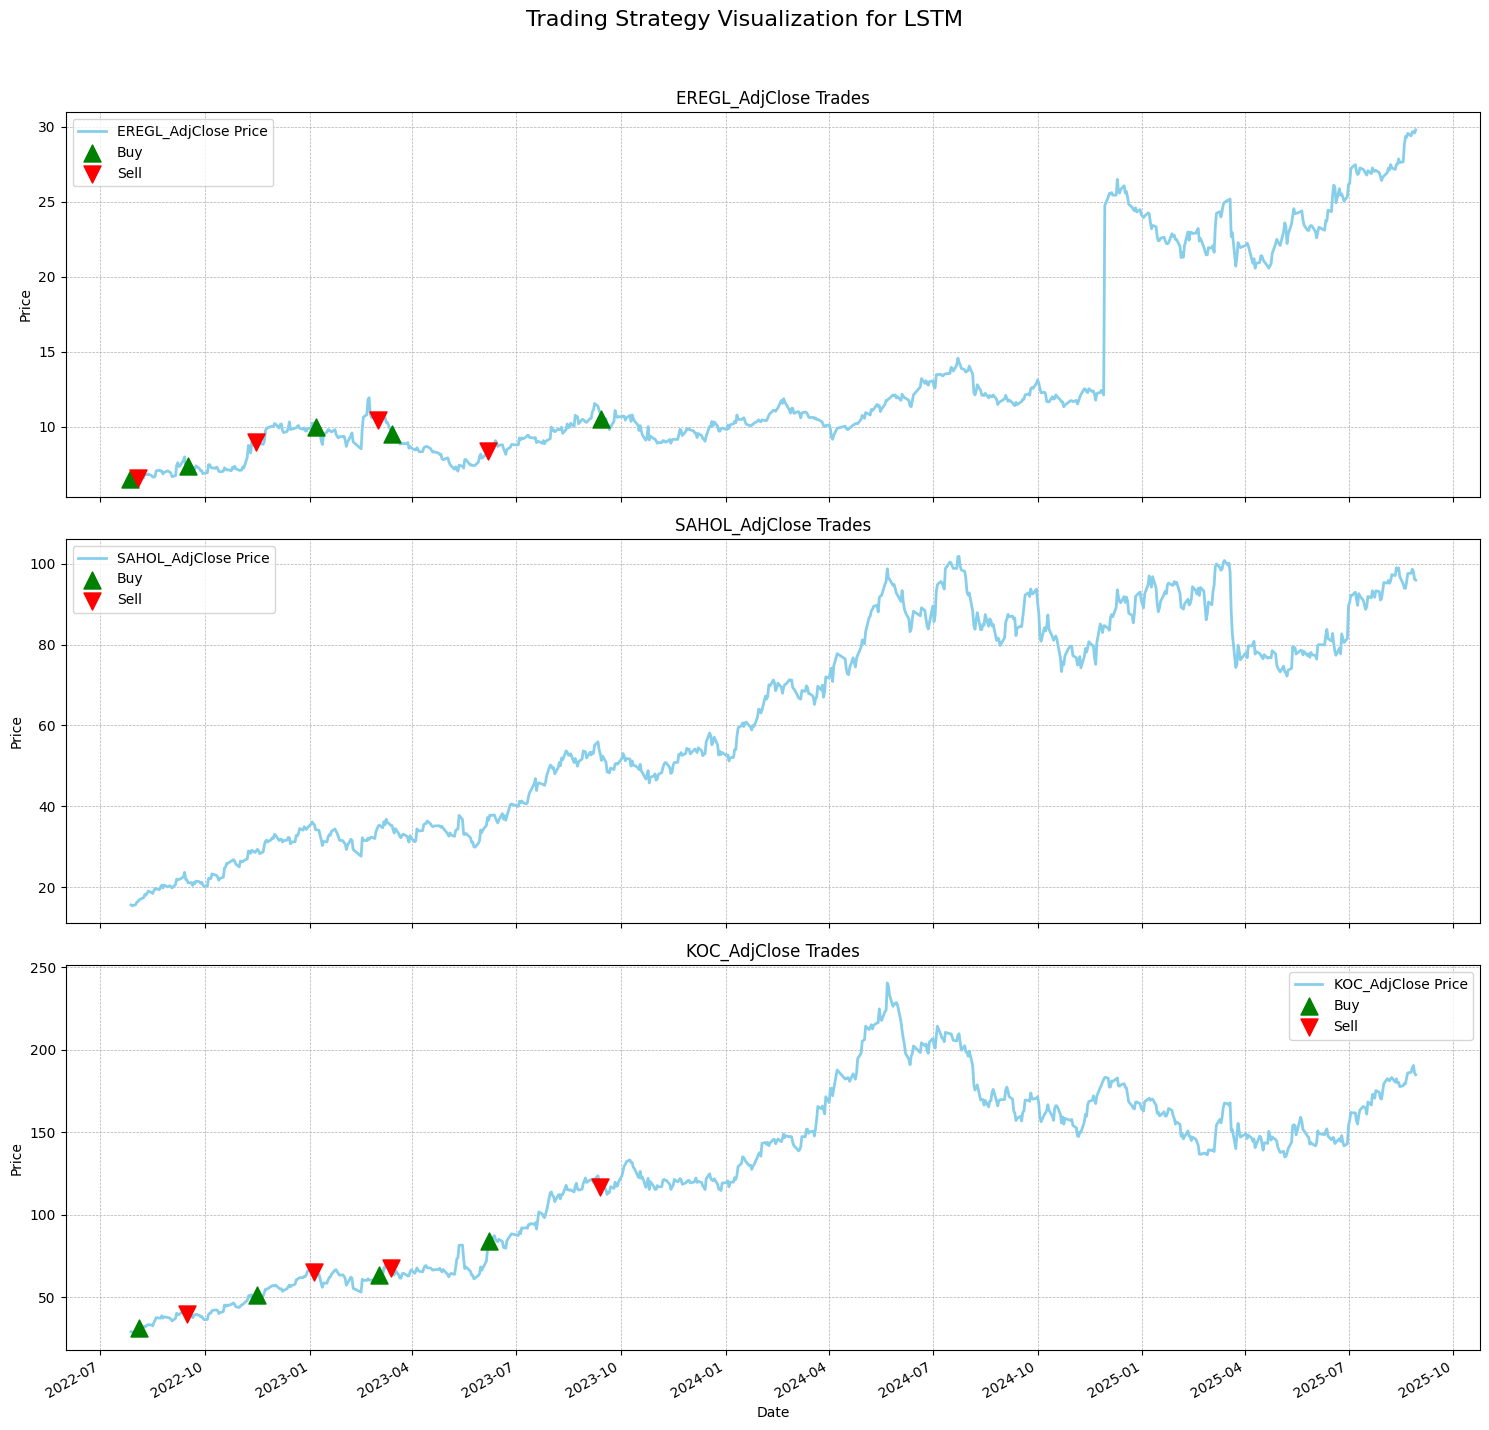

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def evaluate_and_plot_trades(model, df_val, model_name="agent"):
    """
    Evaluates a trained agent and plots its buy/sell trades on a price chart.

    :param model: The trained Stable-Baselines3 model.
    :param df_val: The validation DataFrame.
    :param model_name: A name for the model, used in the plot title and filename.
    """
    logging.info(f"--- Generating trade plot for {model_name} ---")

    # Create a fresh environment with the validation data
    env = MultiAssetTradingEnv(df=df_val, **CONFIG["env"])
    obs, info = env.reset()

    # Store prices and trades
    asset_names = env.price_cols
    prices = {name: [] for name in asset_names}
    trades = []

    done = False
    while not done:
        # Get the date for the current step from the DataFrame's index
        current_date = df_val.index[env.current_step]

        # Store prices for the current step
        current_prices = env.df.loc[env.current_step, asset_names].values
        for i, name in enumerate(asset_names):
            prices[name].append(current_prices[i])

        # Predict the action
        action, _ = model.predict(obs, action_masks=env.action_masks(), deterministic=True)

        # Get the info dict *before* stepping to know the action taken
        executed_action = "hold"
        if action > 0:
            if action % 2 == 1: # Buy
                asset_idx = (action - 1) // 2
                executed_action = "buy"
            else: # Sell
                asset_idx = (action - 2) // 2
                executed_action = "sell"

            if env.action_masks()[action]: # Log only if the trade is valid
                 trades.append({
                    "date": current_date,
                    "asset": asset_names[asset_idx],
                    "price": current_prices[asset_idx],
                    "action": executed_action
                })

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # --- Plotting ---
    fig, axes = plt.subplots(len(asset_names), 1, figsize=(15, 5 * len(asset_names)), sharex=True)
    fig.suptitle(f"Trading Strategy Visualization for {model_name.upper()}", fontsize=16)

    for i, name in enumerate(asset_names):
        ax = axes[i]

        # Plot the asset's price
        asset_prices = prices[name]
        dates = df_val.index[env.window_size + 1 : len(asset_prices) + env.window_size + 1]
        ax.plot(dates, asset_prices, label=f"{name} Price", color='skyblue', linewidth=2)

        # Plot the buy and sell markers
        asset_trades = [t for t in trades if t['asset'] == name]
        buy_dates = [t['date'] for t in asset_trades if t['action'] == 'buy']
        buy_prices = [t['price'] for t in asset_trades if t['action'] == 'buy']
        sell_dates = [t['date'] for t in asset_trades if t['action'] == 'sell']
        sell_prices = [t['price'] for t in asset_trades if t['action'] == 'sell']

        ax.scatter(buy_dates, buy_prices, label='Buy', marker='^', color='green', s=150, alpha=1.0, zorder=5)
        ax.scatter(sell_dates, sell_prices, label='Sell', marker='v', color='red', s=150, alpha=1.0, zorder=5)

        ax.set_ylabel("Price")
        ax.set_title(f"{name} Trades")
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Format the x-axis for better date readability
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        fig.autofmt_xdate()

    plt.xlabel("Date")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

    # Save the plot
    filename = f"trades_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.show()
    plt.close() # Close the figure to free up memory
    logging.info(f"✓ Trade plot saved to '{filename}'")


MODEL_PATH = "trading_model_lstm.zip"
MODEL_NAME = "LSTM"

test_df  = df.loc[(df.index >= df.index[int(len(df)*0.80)])]

# Load the trained agent
try:
    logging.info(f"Loading trained model from '{MODEL_PATH}'...")
    model = MaskablePPO.load(MODEL_PATH)
    logging.info("✓ Model loaded successfully.")
except Exception as e:
    logging.error(f"Error loading model: {e}")

# Generate and save the plot
# (This assumes the evaluate_and_plot_trades function is imported)
evaluate_and_plot_trades(model, test_df, model_name=MODEL_NAME)